# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [3]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

In [4]:
data_pre = np.load('diffusion_advection_29longb.npy').T
data= data_pre[120:-60,:,5:30]
down_data= np.take(np.take(np.take(data,np.arange(0,data.shape[0],8),axis=0),np.arange(0,data.shape[1],8),axis=1),np.arange(0,data.shape[2],1),axis=2)

steps = down_data.shape[2]
width = down_data.shape[0]
width_2 = down_data.shape[1]

x_arr = np.arange(0,width)
y_arr = np.arange(0,width_2)
t_arr = np.arange(0,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')
down_data.shape

(15, 19, 25)

In [19]:
X = np.transpose((t_grid.flatten()/np.max(t_grid), x_grid.flatten()/np.max(y_grid), y_grid.flatten()/np.max(y_grid)))
y = np.float32(down_data.reshape((down_data.size, 1)))
y = y/np.max(y)
y.shape

(7125, 1)

In [20]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [9]:
network = NN(3, [40, 40, 40, 40], 1)
library = Library2D_third(poly_order=0) 
estimator = Threshold(0.025) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 
constraint = LeastSquares() 

Now we instantiate the model and select the optimizer 

In [16]:
model = DeepMoD(network, library, estimator, constraint)
model.load_state_dict(torch.load('runs/15_19_25/model.pt'))
model.eval()

DeepMoD(
  (func_approx): NN(
    (network): Sequential(
      (0): Linear(in_features=3, out_features=40, bias=True)
      (1): Tanh()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): Tanh()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): Tanh()
      (6): Linear(in_features=40, out_features=40, bias=True)
      (7): Tanh()
      (8): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (library): Library2D_third()
  (sparse_estimator): Threshold()
  (constraint): LeastSquares()
)

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

Sparsity masks provide the active and non-active terms in the PDE:

In [29]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape((width,width_2,steps)).detach().numpy()

In [30]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape((width,width_2,steps)).detach().numpy()
uy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape((width,width_2,steps)).detach().numpy()

In [31]:
ut = model(torch.tensor(X, dtype=torch.float32))[1][0].reshape((width,width_2,steps)).detach().numpy()

In [32]:
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,3].reshape((width,width_2,steps)).detach().numpy()
uyy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,4].reshape((width,width_2,steps)).detach().numpy()

In [33]:
import pysindy as ps

In [34]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

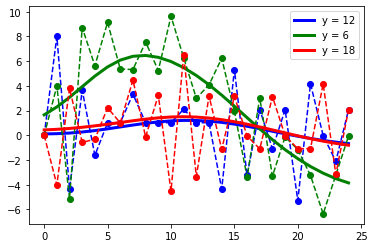

In [35]:
y = down_data[7,5,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'bo--')
plt.plot(t,ut[7,5,:]*np.max(down_data)/np.max(t_grid),'b', label='y = 12',linewidth=3)
y = down_data[7,10,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[7,10,:]*np.max(down_data)/np.max(t_grid),'g', label='y = 6',linewidth=3)
y = down_data[7,15,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[7,15,:]*np.max(down_data)/np.max(t_grid),'r', label='y = 18',linewidth=3)
plt.legend()

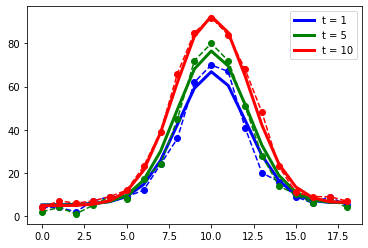

In [16]:
y = down_data[10,:,1]
x = y_arr
plt.plot(x,y, 'bo--')
plt.plot(x,sol[10,:,1]*np.max(down_data),'b', label='t = 1',linewidth=3)
y = down_data[10,:,2]
x = y_arr
plt.plot(x,y, 'go--')
plt.plot(x,sol[10,:,2]*np.max(down_data),'g', label='t = 5',linewidth=3)
y = down_data[10,:,4]
x = y_arr
plt.plot(x,y, 'ro--')
plt.plot(x,sol[10,:,4]*np.max(down_data),'r', label='t = 10',linewidth=3)
plt.legend()

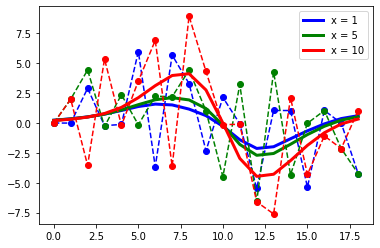

In [17]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(y,x), 'bo--')
plt.plot(x,uy[7,:,1]*np.max(down_data)/np.max(y_grid),'b', label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(y,x), 'go--')
plt.plot(x,uy[7,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(y,x), 'ro--')
plt.plot(x,uy[7,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

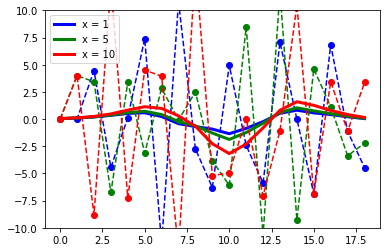

In [39]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'bo--')
plt.plot(x,uyy[7,:,1]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'b',label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'go--')
plt.plot(x,uyy[7,:,2]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'g',label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'ro--')
plt.plot(x,uyy[7,:,4]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'r',label='x = 10',linewidth=3)
plt.ylim(-10,10)
plt.legend()

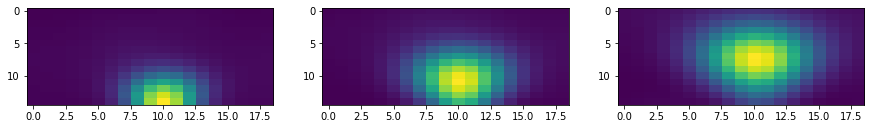

In [42]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.imshow(sol[:,:,1], aspect=0.5)

plt.subplot(1,3, 2)
plt.imshow(sol[:,:,10], aspect=0.5)

plt.subplot(1,3, 3)
plt.imshow(sol[:,:,19], aspect=0.5)


#plt.savefig('reconstruction.pdf')